In [1]:

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb

import util
from util import inv_phi_range
from util import FWHM
import model as m

from tensorflow import keras
from tensorflow.keras import layers
from keras.engine import data_adapter

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from qkeras import QBatchNormalization
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

import hls4ml

/home/diptarko/.local/lib/python3.8/site-packages/hls4ml/converters/__init__.py:24: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [2]:
phi_div  = 64
eta_div  = 64
pt_div   = 64
qual_div = 64

teacher_hidden_neurons = 256
student_hidden_neurons = 8
k_reg          = kernel_regularizer=regularizers.l2(1e-4)
a_reg          = kernel_regularizer=regularizers.l2(1e-4)
ap_fixed       = [18, 5]
target_sparsity = 0

n_epochs     = 100
batch_size   = 1024

lr = 1e-4
device = 0

train   = True
pruning = False

distillation_loss_fn = keras.losses.MeanSquaredError() 
distill_alpha = 0.1
lr_distill = 0.01

# ckpt_file      = "checkpoints/run3_uGMT_nn_recal_checkpoint.h5"

In [ ]:
wandb.login(key="redacted_for_privacy")
wandb.init(
    project = "run3_uGMT_recal_keras_distillation",
    name = "Final2"
)

In [3]:
DATAPATH  = "/home/rardino/data/run3/"
MODELPATH = "./models/run3/"

if not os.path.exists(MODELPATH): os.makedirs(MODELPATH)

/home/diptarko/Refactory/util.py:96: UserWarning: The limits are expected to be the exact float values and not the converted integer counter parts
  warnings.warn("The limits are expected to be the exact float values and not the converted integer counter parts")


train_len =  619108
Train df shape: (619108, 34)
Test  df shape: (32585, 34)
X train shape: (619108, 5)
Y train shape: (619108, 3)
X test  shape: (32585, 5)
Y test  shape: (32585, 3)


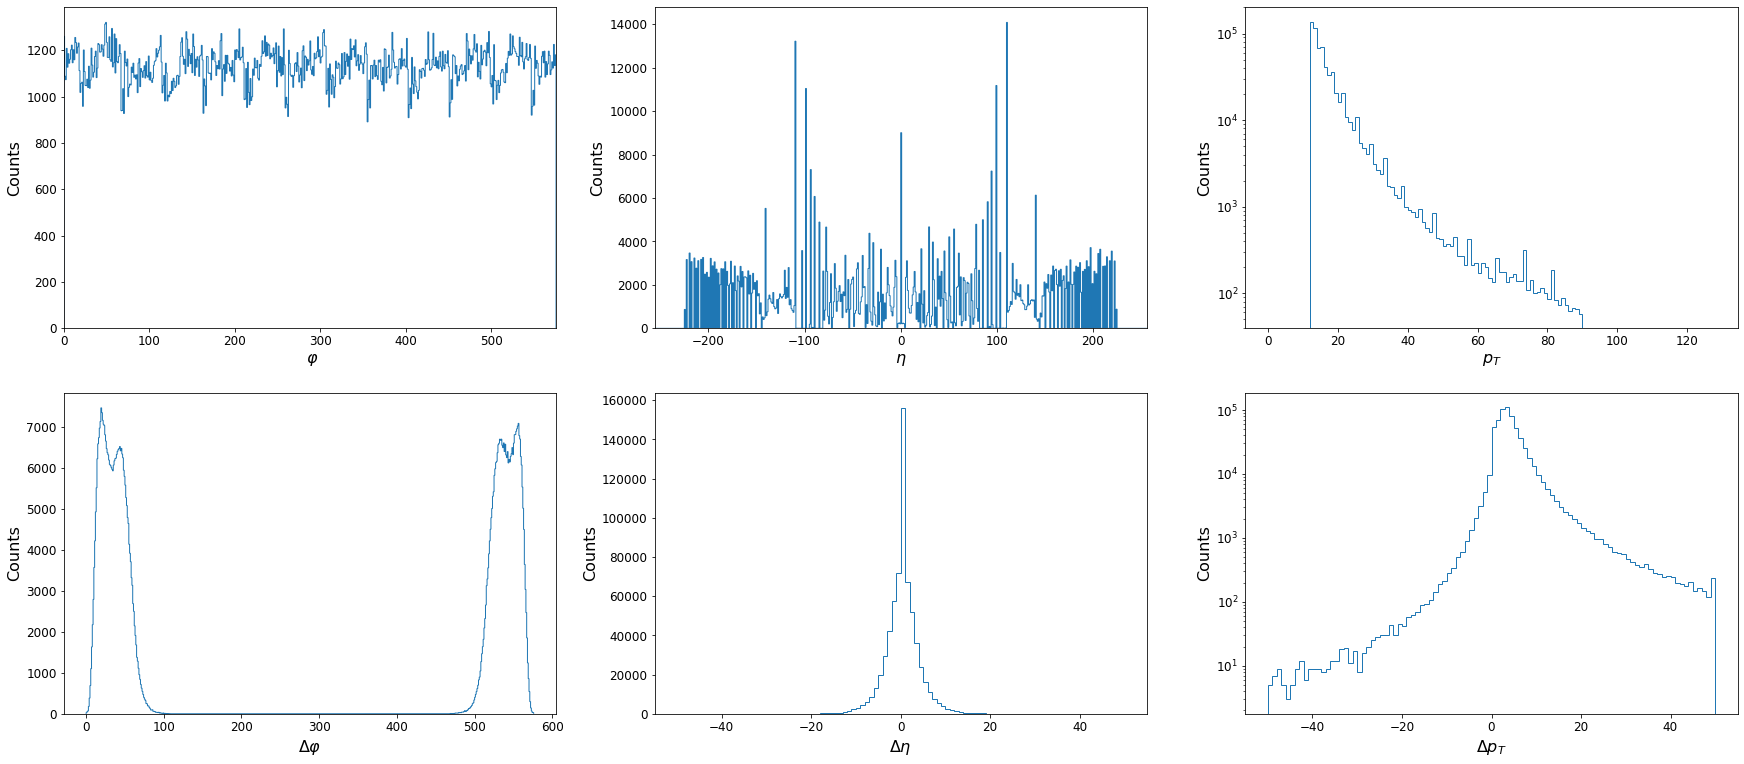

In [4]:
df_base =util.load_data([
    os.path.join(DATAPATH,"run3golden_mm_singles.csv")
                 ])
df_base = util.apply_cut(df_base, 5.5, 45)
train_data, test_data, df_train, df_test = util.preprocess_data(df_base)
x_train, y_train = train_data
x_test, y_test = test_data
util.plot_data(df_base)

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,):
        
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale

            distillation_loss = (self.distillation_loss_fn(teacher_predictions,student_predictions))

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results
    
    
    def predict_step(self, data):
        x, _, _ = data_adapter.unpack_x_y_sample_weight(data)
        return self.student(x, training=False)

In [6]:
teacher = m.make_model(hidden_neurons=teacher_hidden_neurons,
                     k_reg=k_reg,
                     a_reg=a_reg,
                     ap_fixed=ap_fixed)

student =  m.make_model(hidden_neurons=student_hidden_neurons,
                     k_reg=k_reg,
                     a_reg=a_reg,
                     ap_fixed=ap_fixed)
if pruning:
    pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(target_sparsity, begin_step=2000, frequency=100)}
    student = prune.prune_low_magnitude(student, **pruning_params)

opt          = Adam(learning_rate=lr)
losses       = ['logcosh', 'logcosh', 'logcosh']
loss_weights = [1, 1, 1]

2023-08-15 22:58:09.307172: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 22:58:10.383573: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10393 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1
2023-08-15 22:58:10.384512: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10407 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1


In [8]:
student.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hd1 (QDense)                 (None, 8)                 48        
_________________________________________________________________
bn1 (QBatchNormalization)    (None, 8)                 32        
_________________________________________________________________
act1 (QActivation)           (None, 8)                 0         
_________________________________________________________________
hd2 (QDense)                 (None, 8)                 72        
_________________________________________________________________
bn2 (QBatchNormalization)    (None, 8)                 32        
_________________________________________________________________
act2 (QActivation)           (None, 8)                 0         
_________________________________________________________________
hd3 (QDense)                 (None, 8)                

In [ ]:
# We skip the training step by training for only 1 epoch given we have the best model already saved
if train:
    early_stopping = EarlyStopping(
        monitor  = 'val_loss',
        patience = 20
    )
    reduce_lr_on_plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                               factor=0.5,
                                                               patience=5,
                                                               verbose=1,
                                                               mode="auto",
                                                               min_delta=0.001,
                                                               cooldown=0,
                                                               min_lr=0)

    checkpoint = ModelCheckpoint(
        "./checkpoints/teacher.h5",
        monitor           = 'val_loss',
        verbose           = 1,
        save_best_only    = True,
        save_weights_only = False
    )

#     callbacks = [early_stopping, checkpoint,FWHM(x_test,y_test, df_test, True)]
    callbacks = [early_stopping,
#                  checkpoint,
                 reduce_lr_on_plateu, 
                                     FWHM(x_test,
                                      y_test,
                                      df_test,
                                      use_wandb=False,
                                      verbose=True)]


#     callbacks.append(pruning_callbacks.UpdatePruningStep())

    with tf.device(f'/device:GPU:{device}'):    
            teacher.compile(
                loss         = losses,
                loss_weights = loss_weights,
                optimizer    = opt,
            #         metrics=[fwhm]
            )

            teacher.fit(
                x_train, y_train,
                callbacks=callbacks,
                batch_size=batch_size,
                epochs=1,
                validation_split=0.1,
                shuffle=True,
                verbose = 1
                #callbacks = callbacks.callbacks
            )

545/545 [==============================] - 7s 6ms/step - loss: 0.1133 - val_loss: 0.1058
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3800000000000012
FWHM phi uGMT-EXT 0.2340000000000002
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.49100000000000055
-------------------------------------
FWHM phi NN 0.17900000000000016
FWHM eta NN 0.08600000000000019
FWHM pt-NN 0.6300000000000006
-------------------------------------
-------------------------------------


In [44]:
#The checkpoint loading code not needed wshen the notbook is runned
teacher.load_weights("./checkpoints/teacher.h5")

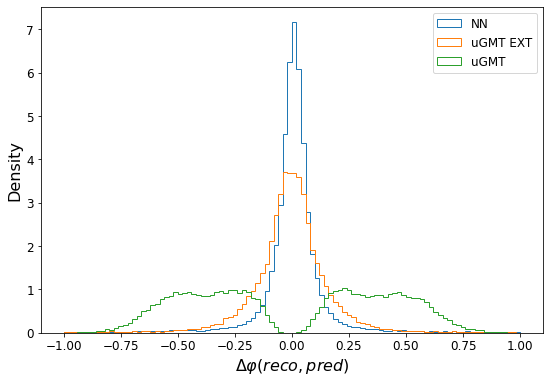

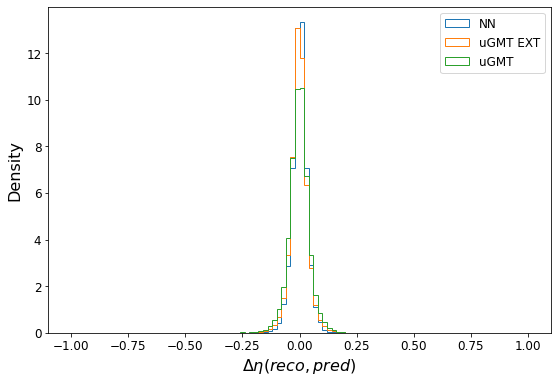

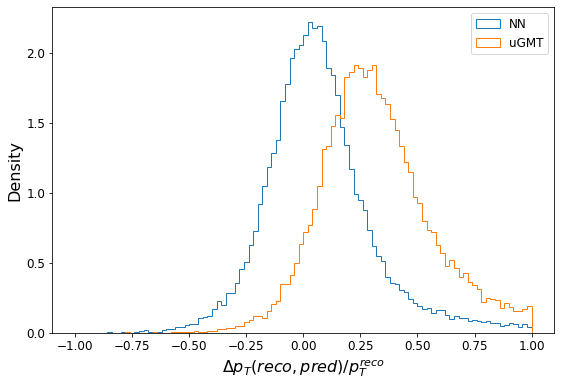

FWHM of delta_phi for the Neural Network Qkeras 0.1200000000000001
FWHM of delta_eta for the Neural Network Qkeras 0.061000000000000054
FWHM of delta_pt for the Neural Network Qkeras 0.41300000000000037


In [45]:
util.evaluate_keras(model = teacher,
                   x_test = x_test,
                   y_test = y_test,
                   df_train = df_train,
                   df_test = df_test,
                   phi_div = phi_div,
                   eta_div = eta_div,
                   pt_div = pt_div,
                   qual_div = qual_div,
                   batch_size = 2048)

In [ ]:
# Initialize and compile distiller
# We skip the training step given we have the best model already saved
distiller = Distiller(student=student, teacher=teacher)

early_stopping = EarlyStopping(
    monitor  = 'val_student_loss',
    patience = 50
)
reduce_lr_on_plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_student_loss",
                                                           factor=0.5,
                                                           patience=10,
                                                           verbose=1,
                                                           mode="auto",
                                                           min_delta=0.001,
                                                           cooldown=0,
                                                           min_lr=0)

checkpoint = ModelCheckpoint(
    MODELPATH + "/qmodel_hl_4__hn_128__qrelu__reg_0p0001l2__ep_20__bs_1024_checkpoint.h5",
    monitor           = 'val_student_loss',
    verbose           = 1,
    save_best_only    = True,
    save_weights_only = False
)


callbacks = [early_stopping,
             reduce_lr_on_plateu,
             FWHM(x_test,
                  y_test,
                  df_test,
                  use_wandb=True,
                  verbose=False)
            ]

callbacks.append(pruning_callbacks.UpdatePruningStep())

with tf.device(f'/device:GPU:{device}'):    
    distiller.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_distill),
        metrics=[],
        student_loss_fn=keras.losses.LogCosh(),
        distillation_loss_fn=distillation_loss_fn,
        alpha=distill_alpha
    )
#     Distill teacher to student
    distiller.fit(x_train, y_train,
                  callbacks=callbacks,
                  verbose = 1,
                  batch_size=batch_size,
                  validation_split=0.1,
                  epochs=500)


In [ ]:
# student.save('student-recalibration/best')

INFO:tensorflow:Assets written to: student-recalibration/best/assets


INFO:tensorflow:Assets written to: student-recalibration/best/assets


In [ ]:
# Loading the best saved model
test_student = tf.keras.models.load_model('student-recalibration/best')

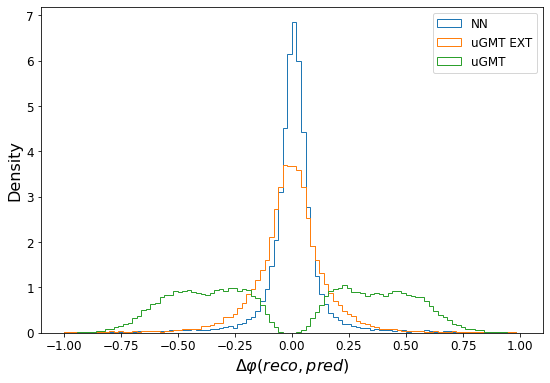

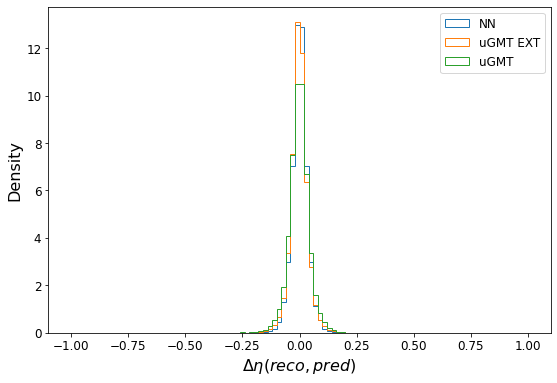

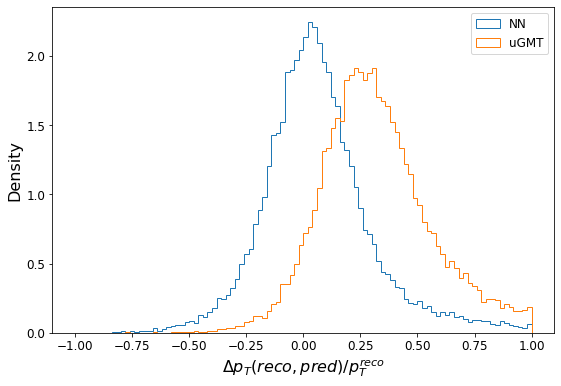

FWHM of delta_phi for the Neural Network Qkeras 0.12400000000000011
FWHM of delta_eta for the Neural Network Qkeras 0.06300000000000017
FWHM of delta_pt for the Neural Network Qkeras 0.41700000000000037


In [51]:
util.evaluate_keras(model = test_student,
                   x_test = x_test,
                   y_test = y_test,
                   df_train = df_train,
                   df_test = df_test,
                   phi_div = phi_div,
                   eta_div = eta_div,
                   pt_div = pt_div,
                   qual_div = qual_div,
                   batch_size = 2048)

In [52]:
test_student.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hd1 (QDense)                 (None, 8)                 48        
_________________________________________________________________
bn1 (QBatchNormalization)    (None, 8)                 32        
_________________________________________________________________
act1 (QActivation)           (None, 8)                 0         
_________________________________________________________________
hd2 (QDense)                 (None, 8)                 72        
_________________________________________________________________
bn2 (QBatchNormalization)    (None, 8)                 32        
_________________________________________________________________
act2 (QActivation)           (None, 8)                 0         
_________________________________________________________________
hd3 (QDense)                 (None, 8)                

In [65]:
config = hls4ml.utils.config_from_keras_model(test_student, granularity='model')
config["Model"]["Precision"] = "ap_fixed<18,6>"
config['Model']['ReuseFactor'] = 4
c_config = hls4ml.converters.create_config(project_name ='nn_ugmt_recal_run3',
                                           output_dir="tmp/hls4ml_test",
                                           clock_period=4,
                                           part='xcvu37p-fsvh2892-2L-e',
                                           backend='Vivado')
c_config['HLSConfig'] = config
c_config['KerasModel'] = test_student
hls_model = hls4ml.converters.convert_from_config(c_config)
hls_model.compile()

Interpreting Sequential
Topology:
Layer name: hd1_input, layer type: InputLayer, input shapes: [[None, 5]], output shape: [None, 5]
Layer name: hd1, layer type: QDense, input shapes: [[None, 5]], output shape: [None, 8]
Layer name: bn1, layer type: QBatchNormalization, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: act1, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: hd2, layer type: QDense, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: bn2, layer type: QBatchNormalization, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: act2, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: hd3, layer type: QDense, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: bn3, layer type: QBatchNormalization, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: act3, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: hd4, layer

Done


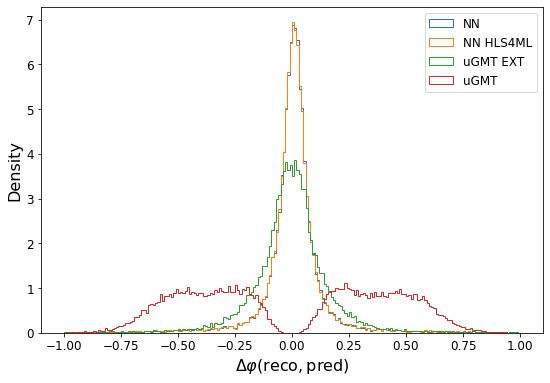

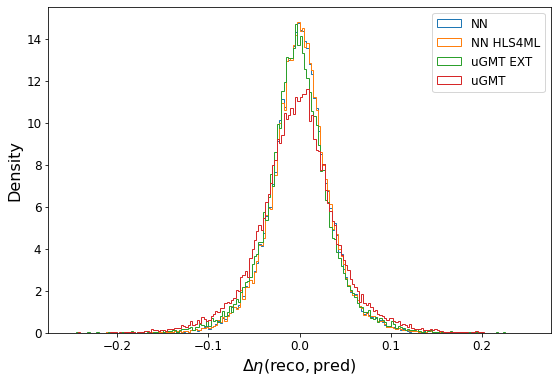

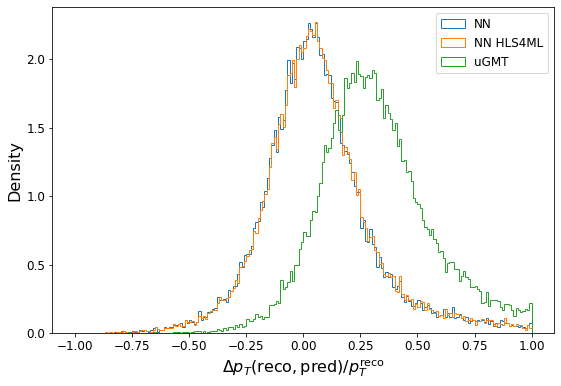

FWHM of delta_phi for the Neural Network Qkeras 0.12400000000000011
FWHM of delta_eta for the Neural Network Qkeras 0.06300000000000017
FWHM of delta_pt for the Neural Network Qkeras 0.41700000000000037

FWHM of delta_phi for the Neural Network HLS4ML 0.123
FWHM of delta_eta for the Neural Network HLS4ML 0.06300000000000017
FWHM of delta_pt for the Neural Network HLS4ML 0.41800000000000037


In [66]:
util.evaluate_hls(hls_model = hls_model,
                  keras_model = test_student,
                   x_test = x_test,
                   y_test = y_test,
                   df_train = df_train,
                   df_test = df_test,
                   phi_div = phi_div,
                   eta_div = eta_div,
                   pt_div = pt_div,
                   qual_div = qual_div
                 )

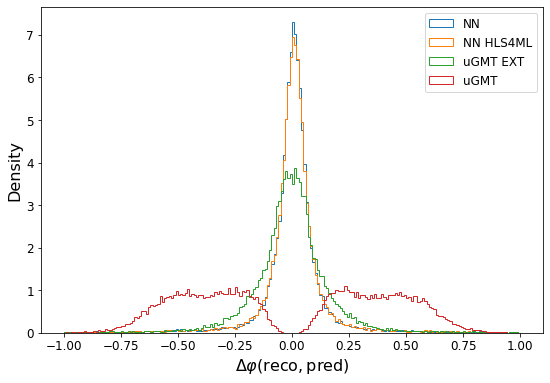

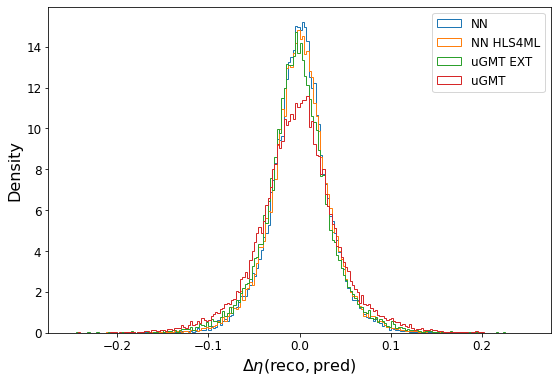

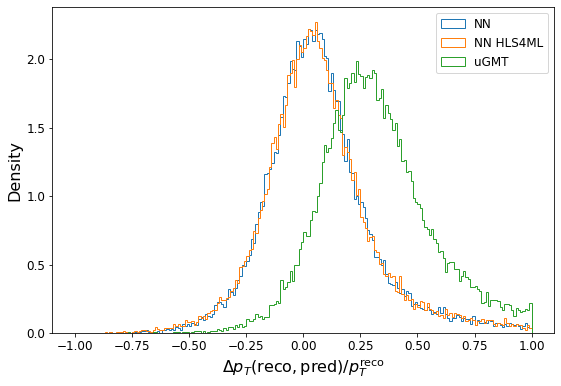

FWHM of delta_phi for the Neural Network Qkeras 0.1200000000000001
FWHM of delta_eta for the Neural Network Qkeras 0.061000000000000054
FWHM of delta_pt for the Neural Network Qkeras 0.41300000000000037

FWHM of delta_phi for the Neural Network HLS4ML 0.123
FWHM of delta_eta for the Neural Network HLS4ML 0.06300000000000017
FWHM of delta_pt for the Neural Network HLS4ML 0.41800000000000037


In [67]:
util.evaluate_hls(hls_model = hls_model,
                  keras_model = teacher,
                   x_test = x_test,
                   y_test = y_test,
                   df_train = df_train,
                   df_test = df_test,
                   phi_div = phi_div,
                   eta_div = eta_div,
                   pt_div = pt_div,
                   qual_div = qual_div
                 )

In [68]:
os.environ["OMP_NUM_THREADS"] = "10"
os.environ['PATH'] = '/home/xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
os.environ['LD_LIBRARY_PATH'] = '/usr/lib64'

hls_logs = hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/home/xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'diptarko' on host 'pcgpu-c2f07-18-01.cern.ch' (Linux_x86_64 version 4.18.0-497.el8.x86_64) on Tue Jul 18 17:08:25 CEST 2023
INFO: [HLS 200-10] On os "CentOS Stream release 8"
INFO: [HLS 200-10] In directory '/home/diptarko/Refactory/tmp/hls4ml_test'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/diptarko/Refactory/tmp/hls4ml_test/nn_ugmt_recal_run3_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/nn_ugmt_recal_run3.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'nn_ugmt_recal_run3_t

INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18>' (firmware/nnet_utils/nnet_dense_latency.h:17:48).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, relu_config17>' (firmware/nnet_utils/nnet_activation.h:40:43).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config16>' (firmware/nnet_utils/nnet_batchnorm.h:37:47).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>' (firmware/nnet_utils/nnet_dense_latency.h:17:48).
INFO: [XFORM 203-502] Unrol

INFO: [HLS 200-489] Unrolling loop 'Product2' (firmware/nnet_utils/nnet_dense_latency.h:40) in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' completely with a factor of 8.
INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:48) in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' completely with a factor of 8.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:54) in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' completely with a factor of 8.
INFO: [HLS 200-489] Unrolling loop 'Accum2' (firmware/nnet_utils/nnet_dense_latency.h:56) in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3,

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config16>'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config16>.0' at call site (firmware/nn_ugmt_recal_run3.cpp:91) by setting 'scale[0].V' to 's16.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config16>.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config16>.0.0' at call site (firmware/nn_ugmt_recal_run3.cpp:91) by setting 'scale[1].V' to 's16.V.1'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:26:1) to 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/nn_ugmt_recal_run3.cpp:87) by setting 'biases[2].V' to 'b14.V.2'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:26:1) to 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/nn_ugmt_recal_run3.cpp:87) by setting 'biases[3].V' to 'b14.V.3'.
INFO: [XFORM 2

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nn_ugmt_recal_run3.cpp:79) by setting 'bias[7].V' to 'b12.V.7'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config10>'(firmware/nnet_utils/nnet_dense_latency.h:26:1) to 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config10>.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/nn_ugmt_recal_run3.cpp:75) by setting 'weights.V' to 'w10.V'.
INFO: [XFORM 203-622] Instantiating f

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0' at call site (firmware/nn_ugmt_recal_run3.cpp:67) by setting 'bias[0].V' to 'b8.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nn_ugmt_recal_run3.cpp:67) by setting 'bias[1].V' to 'b8.V.1'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0' at call site (firmware/nn_ugmt_recal_run3.cpp:55) by setting 'scale[4].V' to 's4.V.4'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0' at call site (firmware/nn_ugmt_recal_run3.cpp:55) by setting 'scale[5].V' to 's4.V.5'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap

INFO: [XFORM 203-11] Balancing expressions in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0.0.0.0.0.0.0.0' (firmware/nnet_utils/nnet_dense_latency.h:26:1)...64 expression(s) balanced.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0' (firmware/nnet_utils/nnet_dense_latency.h:26:1)...39 expression(s) balanced.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18>.0.0.0.0' (firmware/nnet_utils/nnet_dense_latency.h:26:1)...24 expression(s) balanced.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config

INFO: [SCHED 204-61] Pipelining result : Target II = 4, Final II = 4, Depth = 4.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 29.22 seconds; current allocated memory: 274.375 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.18 seconds; current allocated memory: 275.131 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'normalize_ap_fixed_ap_fixed_config4_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'normalize<ap_fixed

INFO: [HLS 200-111]  Elapsed time: 0.07 seconds; current allocated memory: 281.663 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_ap_fixed_ap_fixed_18_6_5_3_0_config14_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_fixed,ap_fixed<18,6,5,3,0>,config14>.0.0.0.0.0.0.0.0.0'.
INFO: [SCHED 204-61] Pipelining result : Target II = 4, Final II = 4, Depth = 4.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.35 seconds; current allocated memory: 282.510 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'normalize_ap_fixed_ap_fixed_config12_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'normalize_ap_fixed_ap_fixed_config12_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0'.
INFO: [HLS 200-111]  Elapsed time: 0.83 seconds; current allocated memory: 307.626 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_ap_fixed_18_6_5_3_0_ap_fixed_18_6_5_3_0_relu_config13_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_ap_fixed_18_6_5_3_0_ap_fixed_18_6_5_3_0_relu_config13_s'.
INFO: [HLS 200-111]  Elapsed time: 0.35 seconds; current allocated memory: 308.848 MB.
INFO: [HLS 200

In [69]:
hls_logs

{'CSynthesisReport': {'TargetClockPeriod': '4.00',
  'EstimatedClockPeriod': '3.397',
  'BestLatency': '39',
  'WorstLatency': '39',
  'IntervalMin': '4',
  'IntervalMax': '4',
  'DSP': '72',
  'FF': '5677',
  'LUT': '11351',
  'BRAM_18K': '0',
  'URAM': '0',
  'AvailableBRAM_18K': '4032',
  'AvailableDSP': '9024',
  'AvailableFF': '2607360',
  'AvailableLUT': '1303680',
  'AvailableURAM': '960'}}